In this notebook, we work with the two-timescale Lorenz-96 model, which is a slightly more complex variant of the commonly used Lorenz-96 system.

In this system, there are $K$ slowly evolving variables $X_k$, that are analogous to the variables of the single-timescale Lorenz-96 system.

For each variable $X_k$, there are $J$ fastly evolving variables $Y_{k,j}$.

The variables evolve according to the following set of equations:

$\frac{d}{dt} X_k = (X_{k+1} - X_{k-2}) X_{k-1} - X_i + F - \frac{hc}{b} \sum_{j=0}J Y_{k,j}$

$\frac{d}{dt} Y_{j,k} = - cbY_{j+1,k} \left( Y_{j+2,k} - Y_{j-1,k} \right) - c Y_{j,k} + \frac{hc}{b} X_k$

Like for the one-timescale variant, there are periodic boundary conditions of both the $k$ and $j$ indexes.

# Generate a time series

In [ ]:
import torch
from matplotlib import pyplot as plt
from time import time
import random as rd
import os
os.chdir('..')
from da_tools.variational.weak_constraint_4dvar import wc4dvar_single_window
from da_tools.system.state import State
from da_tools.observation.operators import random_sparse_noisy_obs
from da_tools.util.initialization import interp_initialization
from da_tools.util.visualization import show_1dseqimg
from da_tools.probability.distributions import DiagonalGaussian
from tensordict import TensorDict

from mdml_sim.lorenz96 import L96Simulator

State(
    Fields: TensorDict(
        fields={
            x: Tensor(shape=torch.Size([1, 1, 36]), device=cpu, dtype=torch.float32, is_shared=False),
            y: Tensor(shape=torch.Size([1, 1, 36, 10]), device=cpu, dtype=torch.float32, is_shared=False)},
        batch_size=torch.Size([1, 1]),
        device=None,
        is_shared=False)
    Time axis: tensor([0]))


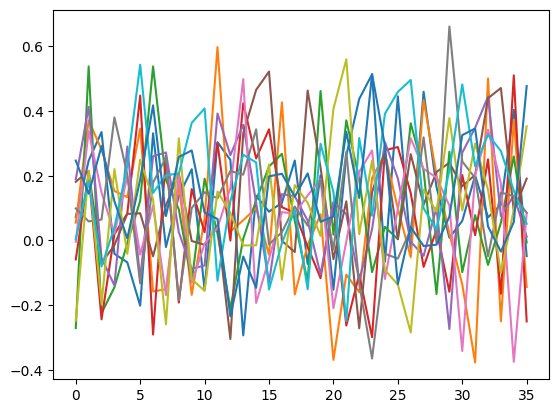

In [ ]:
# Define a target initial state


f = 10 # forcing
K = 36 # number of slow variables
J = 10 # number of fast variables for each slow variable
initial_state_slow = f * (0.5 + torch.randn((1, 1, K,))) / max(J, 50)
initial_state_fast = f * (0.5 + torch.randn((1, 1, K, J))) / max(J, 50)
initial_state = State(TensorDict(x=initial_state_slow, y=initial_state_fast))
plt.plot(initial_state.fields['x'].squeeze())
plt.plot(initial_state.fields['y'].squeeze())

print(initial_state)

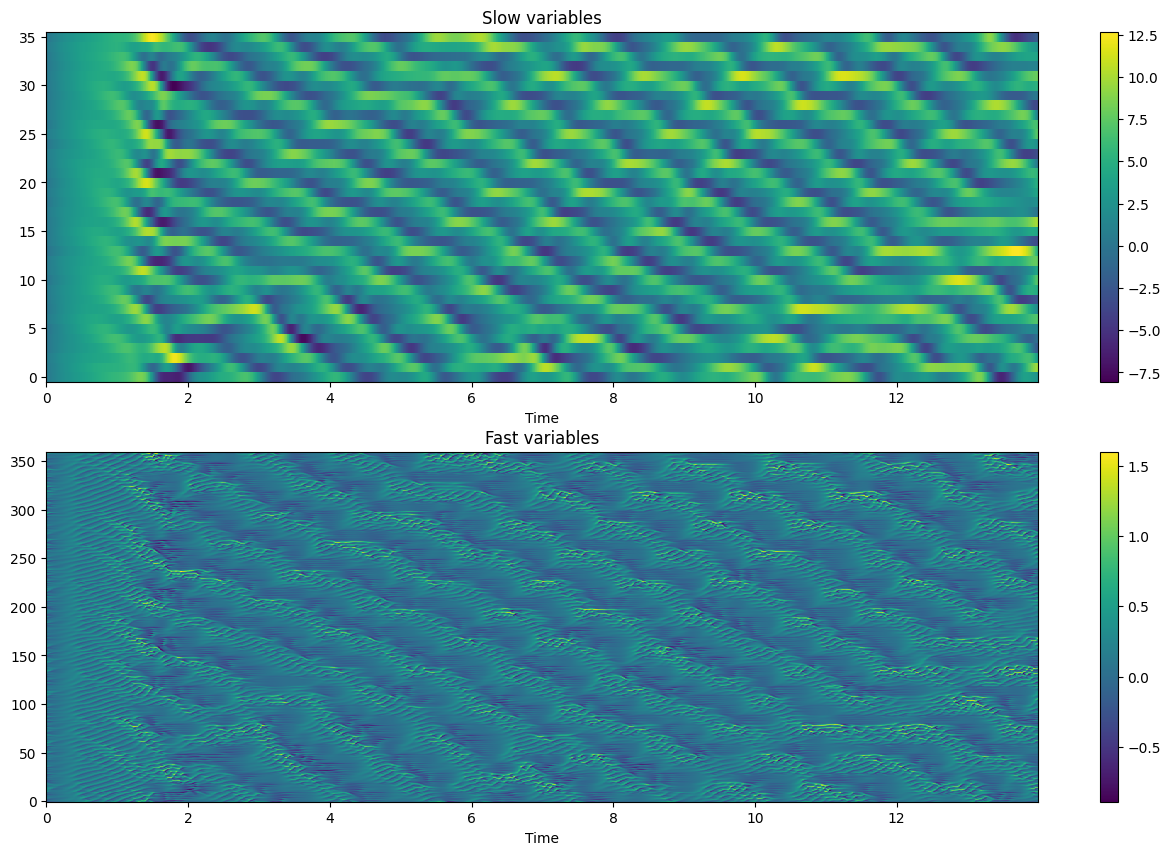

In [ ]:
# Generate a time series from the defined initial_condition using our L96 simulator
forward_operator = L96Simulator("two_level", forcing=f, b=10, c=10, h=1)
ts_length = 1400
time_step = 0.01 # one time step = 0.01 second
forecast_steps = torch.arange(0, ts_length * time_step, time_step)
ts = forward_operator.integrate(time=forecast_steps, state=(initial_state.fields['x'].flatten(0,1), initial_state.fields['y'].flatten(0,1)))

fig, ax = plt.subplots(2, 1, figsize=(16,10))

show_1dseqimg(ts[0][0].T, dt=time_step, ax=ax[0], x_label="Time", title="Slow variables")
show_1dseqimg(ts[1][0].flatten(1,2).T, dt=time_step, ax=ax[1], x_label="Time", title="Fast variables")

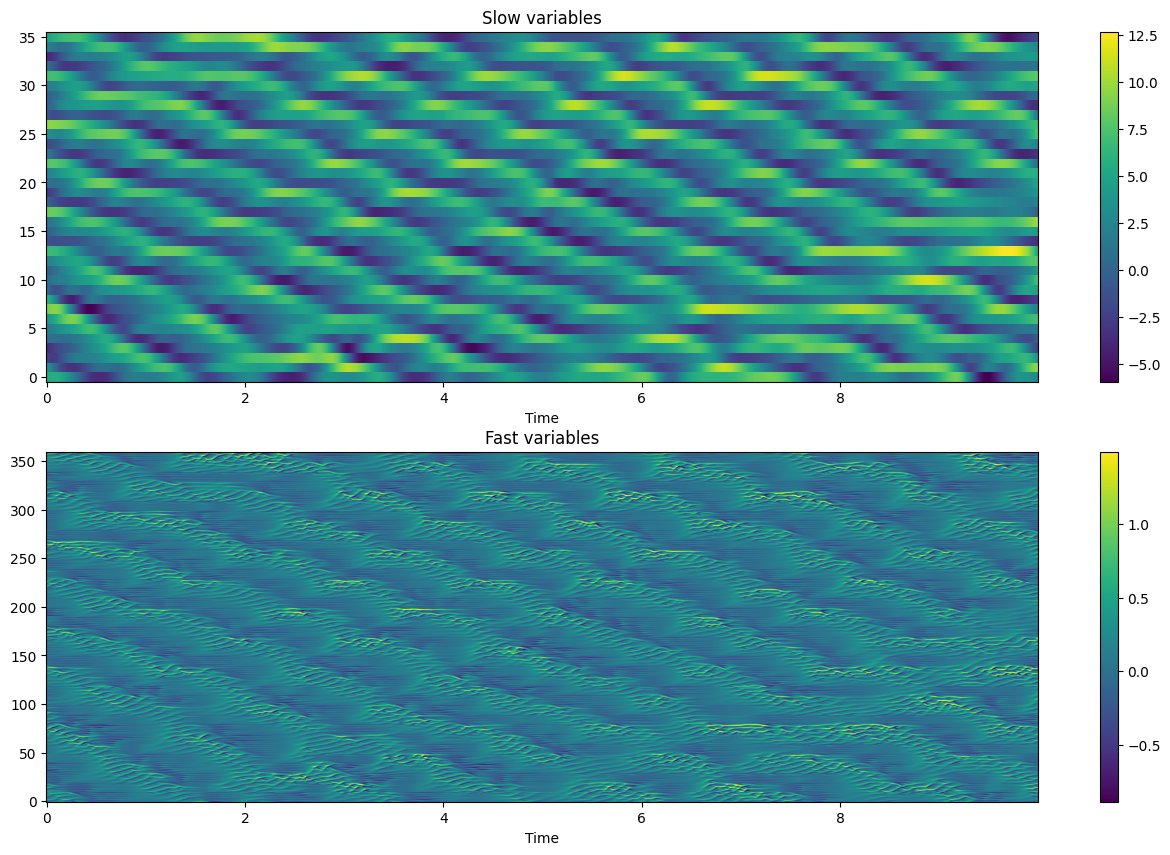

In [ ]:
cutoff_time = 4
cutoff_index = int(cutoff_time / time_step)
forecast_steps = torch.arange(0, ts_length * time_step - cutoff_time, time_step)

state_tensordict = TensorDict(x=ts[0][:, cutoff_index:], y=ts[1][:, cutoff_index:])
true_ts = State(state_tensordict, time_axis=forecast_steps)

fig, ax = plt.subplots(2, 1, figsize=(16,10))

show_1dseqimg(true_ts.fields['x'][0].T, dt=time_step, ax=ax[0], x_label="Time", title="Slow variables")
show_1dseqimg(true_ts.fields['y'][0].flatten(1,2).T, dt=time_step, ax=ax[1], x_label="Time", title="Fast variables")

# Assimilate observations from both fast and slow variables

Here we assume that sparse and noisy observations are available for both fast and slow variables, and we will attempt to reconstruct an estmation of the whole system all at once.

In [ ]:
p_obs = {'x': 0.25, 'y': 0.25} # for all variables, 75% of the observations are masked
p_obs = {'x': 0.25, 'y': 0.1} # the fast variables are less frequently observed than the slow ones
obs_noise_sd = {'x': 1, 'y': 0.1} # the observations on the fast variables are less noisy (which reflects their smaller variability)

groundtruth, obs_op, observations = random_sparse_noisy_obs(true_ts, obs_noise_sd, p_obs)

In [ ]:
# we build an initial guess for the initial state, using the available observations
# We use nearest interpolation
initialization = interp_initialization(observations, kind="nearest")  # state estimate for all time points

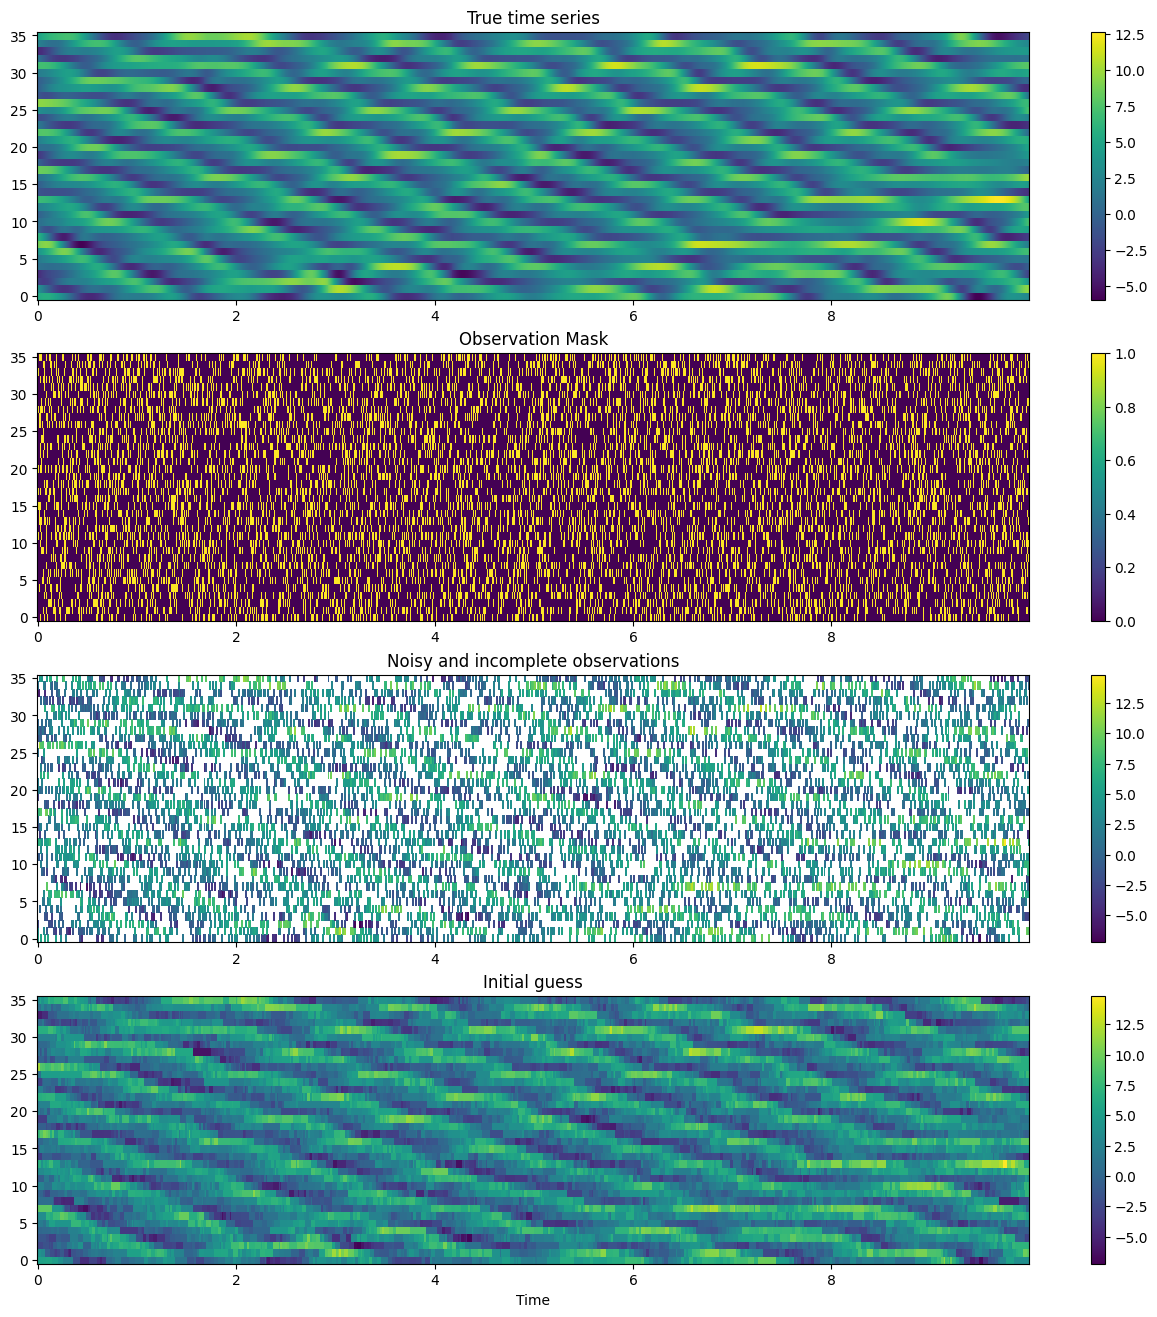

In [ ]:
valid_obs_x = observations.state.fields['x'][0].T
valid_obs_x[torch.logical_not(observations.mask.fields['x'][0].T)] = torch.nan

fig, ax = plt.subplots(4, 1, figsize=(16,16))

show_1dseqimg(true_ts.fields['x'][0].T, dt=time_step, ax=ax[0], title="True time series")
show_1dseqimg(observations.mask.fields['x'][0].T, dt=time_step, ax=ax[1], title="Observation Mask")
show_1dseqimg(valid_obs_x, dt=time_step, ax=ax[2], title="Noisy and incomplete observations")
show_1dseqimg(initialization.fields['x'][0].T, dt=time_step, ax=ax[3], title="Initial guess", x_label="Time")

Text(0.5, 1.0, 'Initial guess')

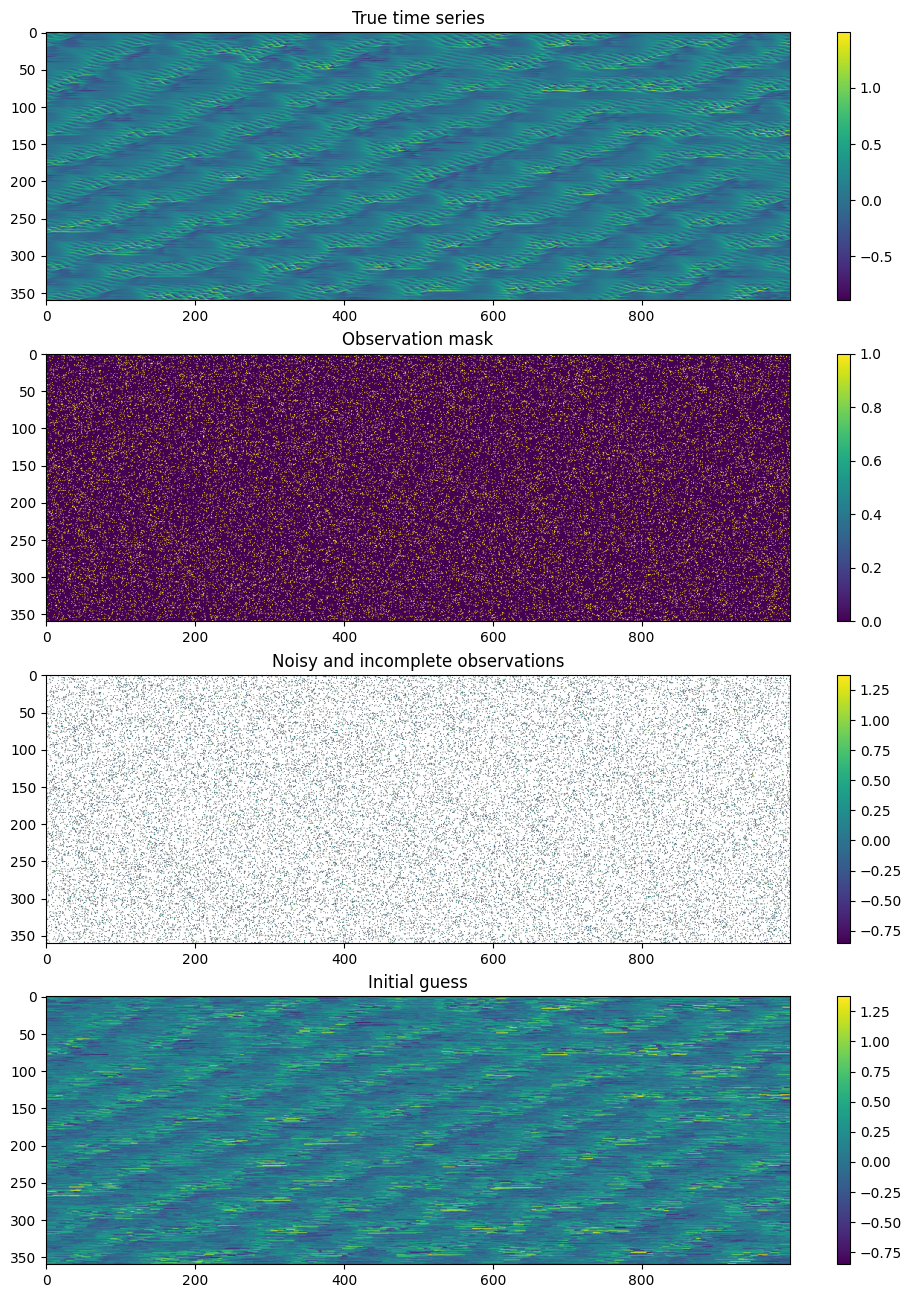

In [ ]:
valid_obs_y = observations.state.fields['y'][0].flatten(1,2).T
valid_obs_y[torch.logical_not(observations.mask.fields['y'][0].flatten(1,2).T)] = torch.nan

fig, ax = plt.subplots(4, 1, figsize=(12,16))

#show_1dseqimg(true_ts.fields['y'][0].flatten(1,2).T, dt=time_step, ax=ax[0], title="True time series")
im0 = ax[0].imshow(true_ts.fields['y'][0].flatten(1,2).T)
fig.colorbar(im0, ax=ax[0])
ax[0].set_title('True time series')
#show_1dseqimg(observations.mask.fields['y'][0].flatten(1,2).T, dt=time_step, ax=ax[1], title="Observation Mask")
im1 = ax[1].imshow(observations.mask.fields['y'][0].flatten(1,2).T)
fig.colorbar(im1, ax=ax[1])
ax[1].set_title('Observation mask')
#show_1dseqimg(valid_obs_y, dt=time_step, ax=ax[2], title="Noisy and incomplete observations")
im2 = ax[2].imshow(valid_obs_y)
fig.colorbar(im2, ax=ax[2])
ax[2].set_title('Noisy and incomplete observations')
#show_1dseqimg(initialization.fields['y'][0].flatten(1,2).T, dt=time_step, ax=ax[3], title="Initial guess", x_label="Time")
im3 = ax[3].imshow(initialization.fields['y'][0].flatten(1,2).T)
fig.colorbar(im3, ax=ax[3])
ax[3].set_title('Initial guess')

In [ ]:
n_steps = true_ts.time_axis.nelement()

model_error_distribs = DiagonalGaussian(TensorDict(x=torch.zeros(1, n_steps - 1, K), 
                                                   y=torch.zeros(1, n_steps-1, K, J)),
                                        TensorDict(x=torch.ones(1, n_steps - 1, K),
                                                   #y=torch.ones(1, n_steps-1, K, J)))
                                                   y=torch.ones(1, n_steps-1, K, J)*5))


We use a higher standard deviation for the model error on the fast variables, reflecting the fact that they vary faster and are more difficult to predict.

In [ ]:
# we define a simple one-time-step function in order to fit the da-tools conventions
# In order to use the 4Dvar function, you should always have a function like this taking the state, dt, dynamic_inputs and static_inputs

def next_step_function(x: State, dt: float, dynamic_inputs: State, static_inputs: State):
    B, T = x.fields.batch_size[:2]
    x_tuple = (x.fields.reshape(-1)["x"], x.fields.reshape(-1)["y"]) # combine batch and time dimensions, leave others intact
    integrated = forward_operator.integrate(torch.arange(2) * dt, x_tuple)
    new_fields = TensorDict(x=integrated[0][:,1].unsqueeze(0), 
                            y=integrated[1][:,1].unsqueeze(0), 
                            batch_size=(B,T))
    return State(new_fields, time_axis=x.time_axis + dt)  # return State object, advancing time

In [ ]:
# This should take a few minutes to run
t0 = time()
assimilated_states = wc4dvar_single_window(next_step_function, 
                                          observations, 
                                          obs_op, 
                                          model_error_distribs,
                                          x_init=initialization, 
                                          optimizer_pars={'lr': 1e-1},
                                          alpha=1e4,
                                          n_steps=100,
                                          verbose=0)                                       
print(f'Total time for the 4Dvar optimization: {time() - t0} seconds')

assimilated_states = assimilated_states.detach()

Total time for the 4Dvar optimization: 170.2225091457367 seconds


torch.Size([1000, 36])
MSE for the reconstruction of the slow variables: 0.010553723201155663


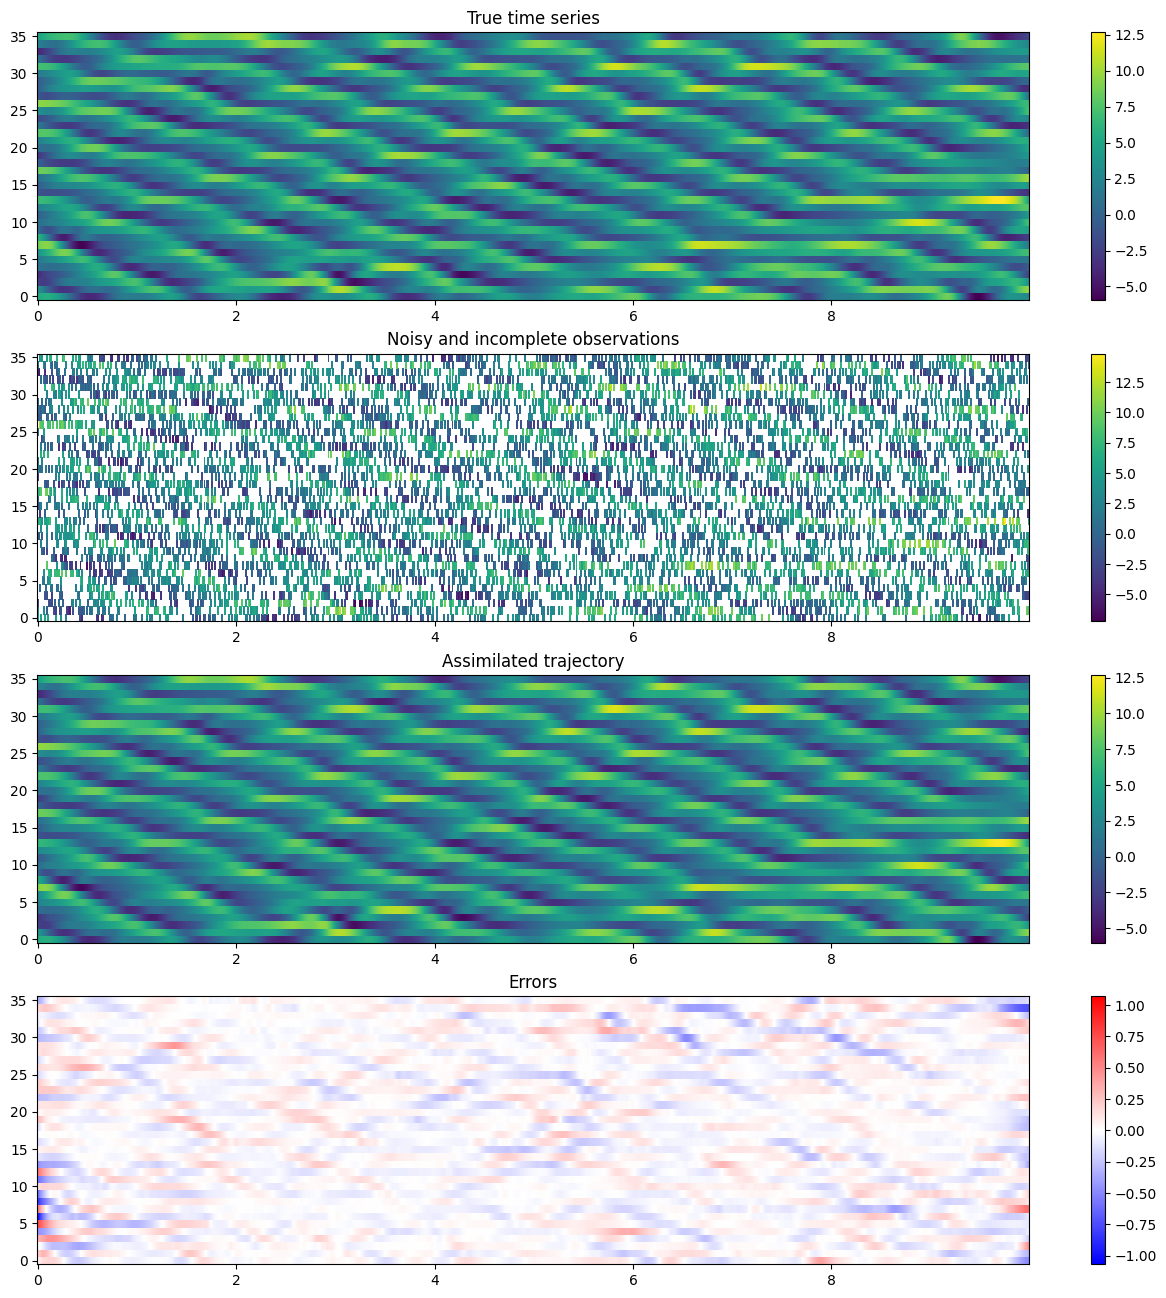

In [ ]:
assimilated_x = assimilated_states.fields['x'][0]
print(assimilated_x.shape)

errors_x = (assimilated_states - true_ts).fields['x'][0]
vmax_abs = torch.max(torch.abs(errors_x))

fig, ax = plt.subplots(4, 1, figsize=(16,16))
show_1dseqimg(true_ts.fields['x'][0].T, dt=time_step, ax=ax[0], title="True time series")
show_1dseqimg(valid_obs_x, dt=time_step, ax=ax[1], title="Noisy and incomplete observations")
show_1dseqimg(assimilated_x.T, dt=time_step, ax=ax[2], title="Assimilated trajectory")
show_1dseqimg(errors_x.T, dt=time_step, ax=ax[3], title="Errors", cmap="bwr", center_on_zero=True)

print(f"MSE for the reconstruction of the slow variables: {torch.mean(errors_x **2)}")

torch.Size([1000, 36, 10])
MSE for the reconstruction of the fast variables: 0.023525232449173927


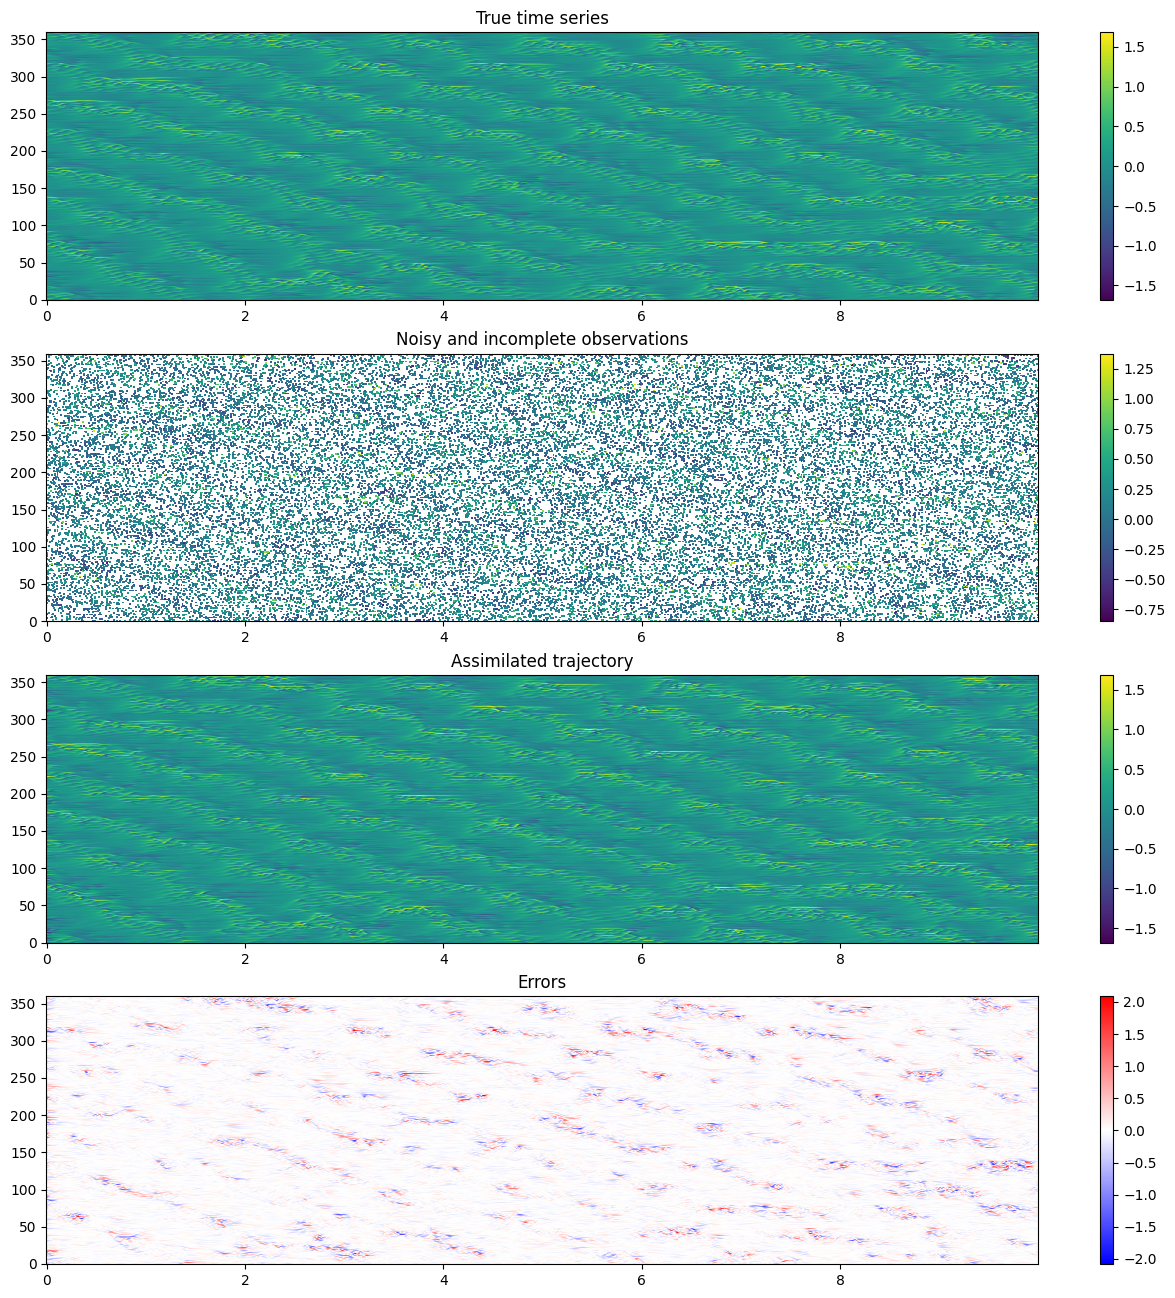

In [ ]:
assimilated_y = assimilated_states.fields['y'][0]
print(assimilated_y.shape)

errors_y = (assimilated_states - true_ts).fields['y'][0]
vmax_abs = torch.max(torch.abs(assimilated_y))

fig, ax = plt.subplots(4, 1, figsize=(16,16))
show_1dseqimg(true_ts.fields['y'][0].flatten(1,2).T, dt=time_step, ax=ax[0], vmin=-vmax_abs, vmax=vmax_abs, title="True time series")
show_1dseqimg(valid_obs_y, dt=time_step, ax=ax[1], title="Noisy and incomplete observations")
show_1dseqimg(assimilated_y.flatten(1,2).T, dt=time_step, ax=ax[2], vmin=-vmax_abs, vmax=vmax_abs, title="Assimilated trajectory")
show_1dseqimg(errors_y.flatten(1,2).T, dt=time_step, ax=ax[3], title="Errors", cmap="bwr", center_on_zero=True)

print(f"MSE for the reconstruction of the fast variables: {torch.mean(errors_y **2)}")

The reconstruction of the slow variables is quite accurate and, as expected for weak-constraint 4D-Var, has higher errors close to the boundaries of the observation window. The reconstruction errors for the fast variable is also overall satisfying, and mostly peaks in small regions that have a very fast evolution and a relatively low density of observations.

# Use only observations and dynamics from the slow variables

Here we do not observe the fast variables at all, and assume that their influence on the slow variables is completely unknown. It should then be accounted for by the model errors in weak-constraint 4D-Var, but very crudely.

In [ ]:
p_obs = {'x': 0.25}
obs_noise_sd = {'x': 1}

true_ts_x = State(true_ts.fields['x'], true_ts.time_axis)
groundtruth, obs_op, observations = random_sparse_noisy_obs(true_ts_x, obs_noise_sd, p_obs)

In [ ]:
# we build an initial guess for the initial state, using the available observations
# We use nearest interpolation
initialization = interp_initialization(observations, kind="nearest")  # state estimate for all time points

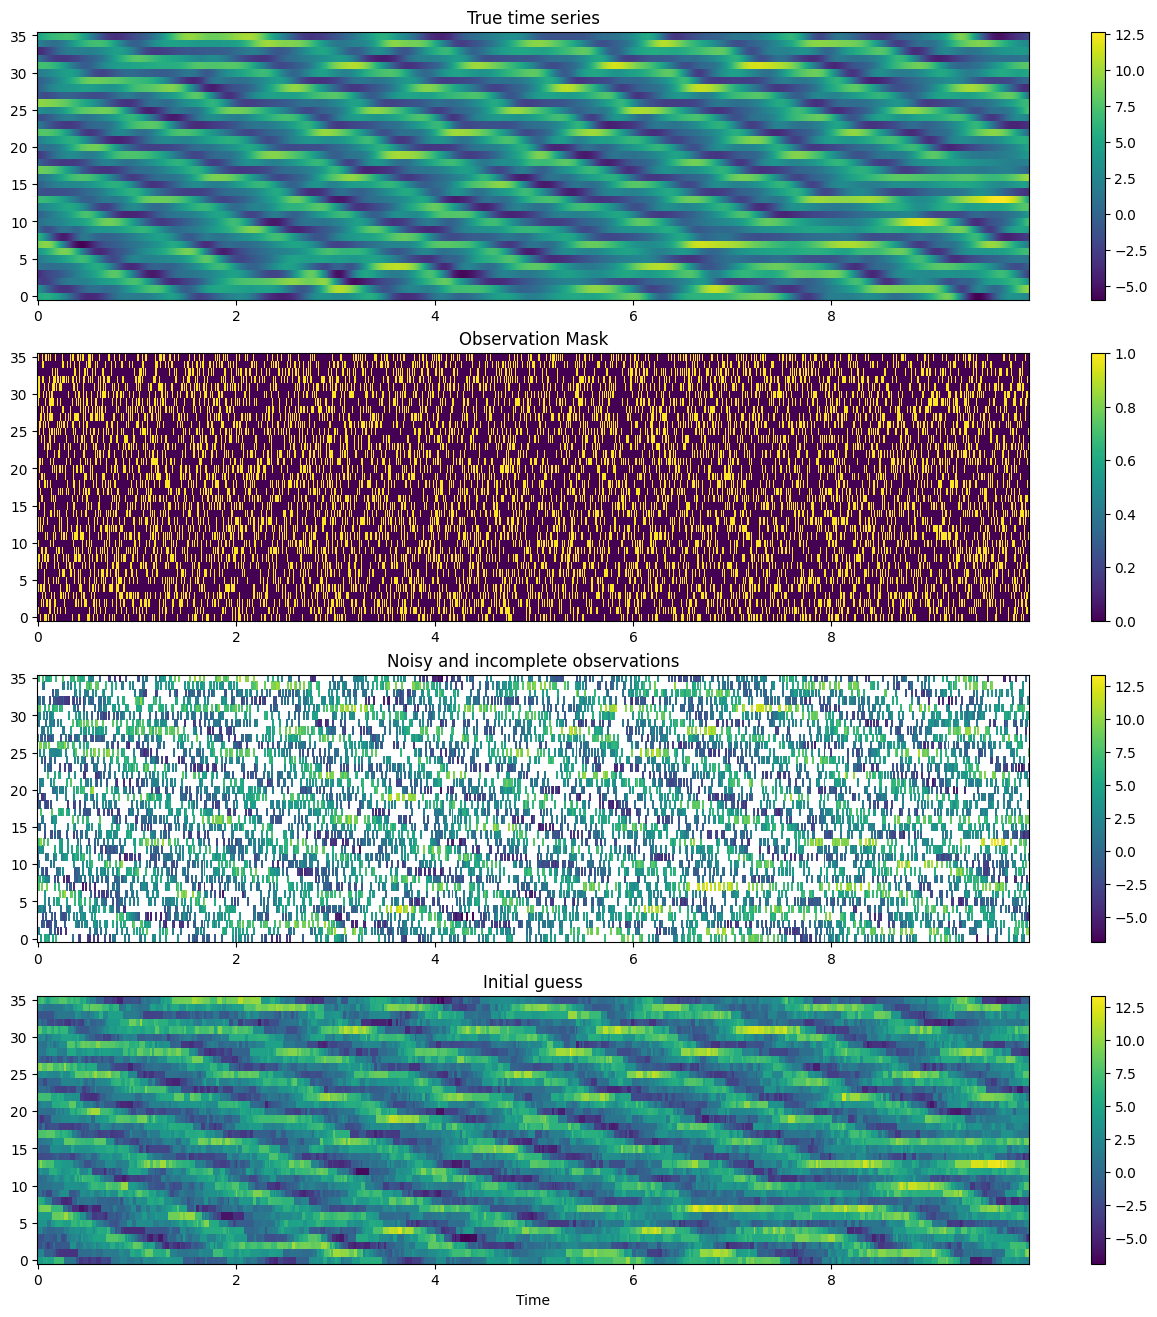

In [ ]:
valid_obs_x = observations.state.fields['x'][0].T
valid_obs_x[torch.logical_not(observations.mask.fields['x'][0].T)] = torch.nan

fig, ax = plt.subplots(4, 1, figsize=(16,16))

show_1dseqimg(true_ts.fields['x'][0].T, dt=time_step, ax=ax[0], title="True time series")
show_1dseqimg(observations.mask.fields['x'][0].T, dt=time_step, ax=ax[1], title="Observation Mask")
show_1dseqimg(valid_obs_x, dt=time_step, ax=ax[2], title="Noisy and incomplete observations")
show_1dseqimg(initialization.fields['x'][0].T, dt=time_step, ax=ax[3], title="Initial guess", x_label="Time")

In [ ]:
n_steps = true_ts.time_axis.nelement()

model_error_distribs = DiagonalGaussian(TensorDict(x=torch.zeros(1, n_steps - 1, K)),
                                        TensorDict(x=torch.ones(1, n_steps - 1, K)))


In [ ]:
# we define a simple one-time-step function in order to fit the da-tools conventions
# In order to use the 4Dvar function, you should always have a function like this taking the state, dt, dynamic_inputs and static_inputs

forward_operator_x = L96Simulator("one_level", forcing=f)

def next_step_function(x: State, dt: float, dynamic_inputs: State, static_inputs: State):
    B, T = x.fields.batch_size[:2]
    x_tensor = x.fields.reshape(-1)["x"]  # combine batch and time dimensions, leave others intact
    integrated = forward_operator_x.integrate(torch.arange(2) * dt, x_tensor)[:, 1]
    new_fields = TensorDict(x=integrated.unsqueeze(0), batch_size=(B,T))
    return State(new_fields, time_axis=x.time_axis + dt)  # return State object, advancing time

In [ ]:
t0 = time()
assimilated_states = wc4dvar_single_window(next_step_function, 
                                          observations, 
                                          obs_op, 
                                          model_error_distribs,
                                          x_init=initialization, 
                                          optimizer_pars={'lr': 1e-1},
                                          alpha=1e2,
                                          n_steps=50,
                                          verbose=0)                                       
print(f'Total time for the 4Dvar optimization: {time() - t0} seconds')

assimilated_states = assimilated_states.detach()

Total time for the 4Dvar optimization: 16.003282070159912 seconds


torch.Size([1000, 36])
MSE for the reconstruction of the slow variables: 0.05814410373568535


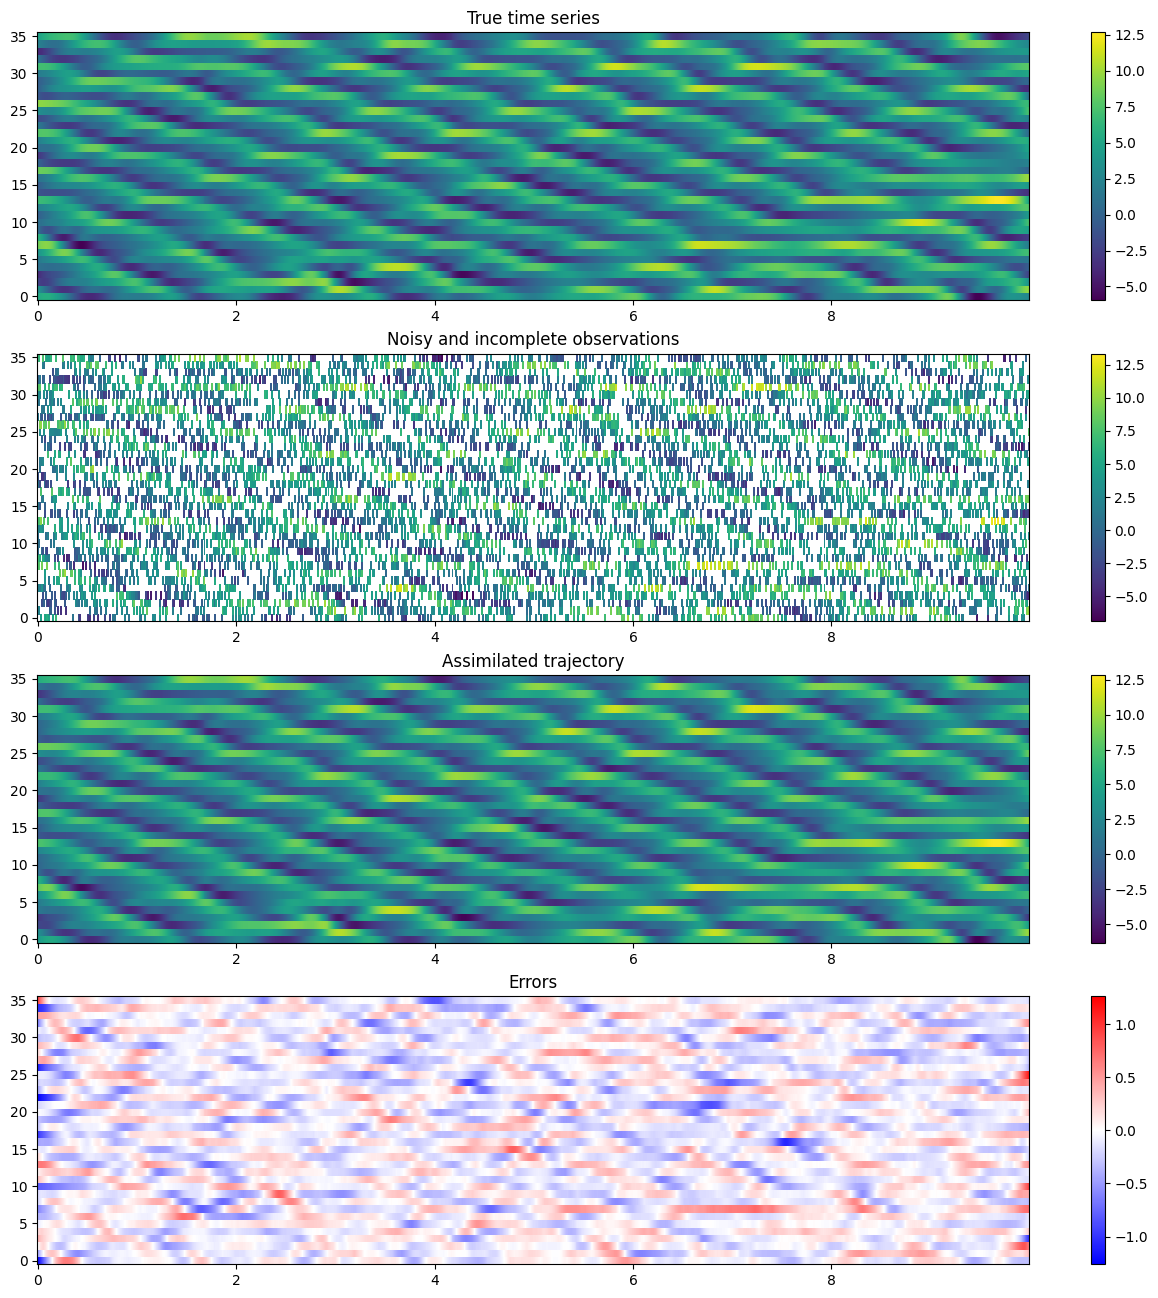

In [ ]:
errors = (assimilated_states.fields['x'] - true_ts.fields['x'])[0]
print(errors.shape)
vmax_abs = torch.max(torch.abs(errors))

fig, ax = plt.subplots(4, 1, figsize=(16,16))
show_1dseqimg(true_ts.fields['x'][0].T, dt=time_step, ax=ax[0], title="True time series")
show_1dseqimg(valid_obs_x, dt=time_step, ax=ax[1], title="Noisy and incomplete observations")
show_1dseqimg(assimilated_states.fields['x'][0].T, dt=time_step, ax=ax[2], title="Assimilated trajectory")
#show_1dseqimg(errors.T, dt=time_step, ax=ax[3], title="Errors", cmap="bwr")
show_1dseqimg(errors.T, dt=time_step, ax=ax[3], title="Errors", cmap="bwr", center_on_zero=True)

print(f"MSE for the reconstruction of the slow variables: {torch.mean(errors **2)}")

As expected, ignoring the effect of the fast variables has a strong negative impact on the reconstruction of the slow variables.

# Observe slow variables only, but use the complete dynamical system

Here, we again have no observations for the fast variables, but we will still try to infer them along with the slow ones using the known equations of the system, which should largely improve the reconstruction of the slow variables as well.

In [ ]:
p_obs = {'x': 0.25, 'y': 0.} # no observations at all for the fast variables
obs_noise_sd = 1.0 # will only be used for the slow variables

groundtruth, obs_op, observations = random_sparse_noisy_obs(true_ts, obs_noise_sd, p_obs)

In [ ]:
# we build an initial guess for the initial state, using the available observations
# We use nearest interpolation
initialization = interp_initialization(observations, kind="nearest", default_value=0)  # state estimate for all time points

As an initial guess for the fast variables, we will simply use an uniformly zero time series, as indicated by the "default_value=0" argument.

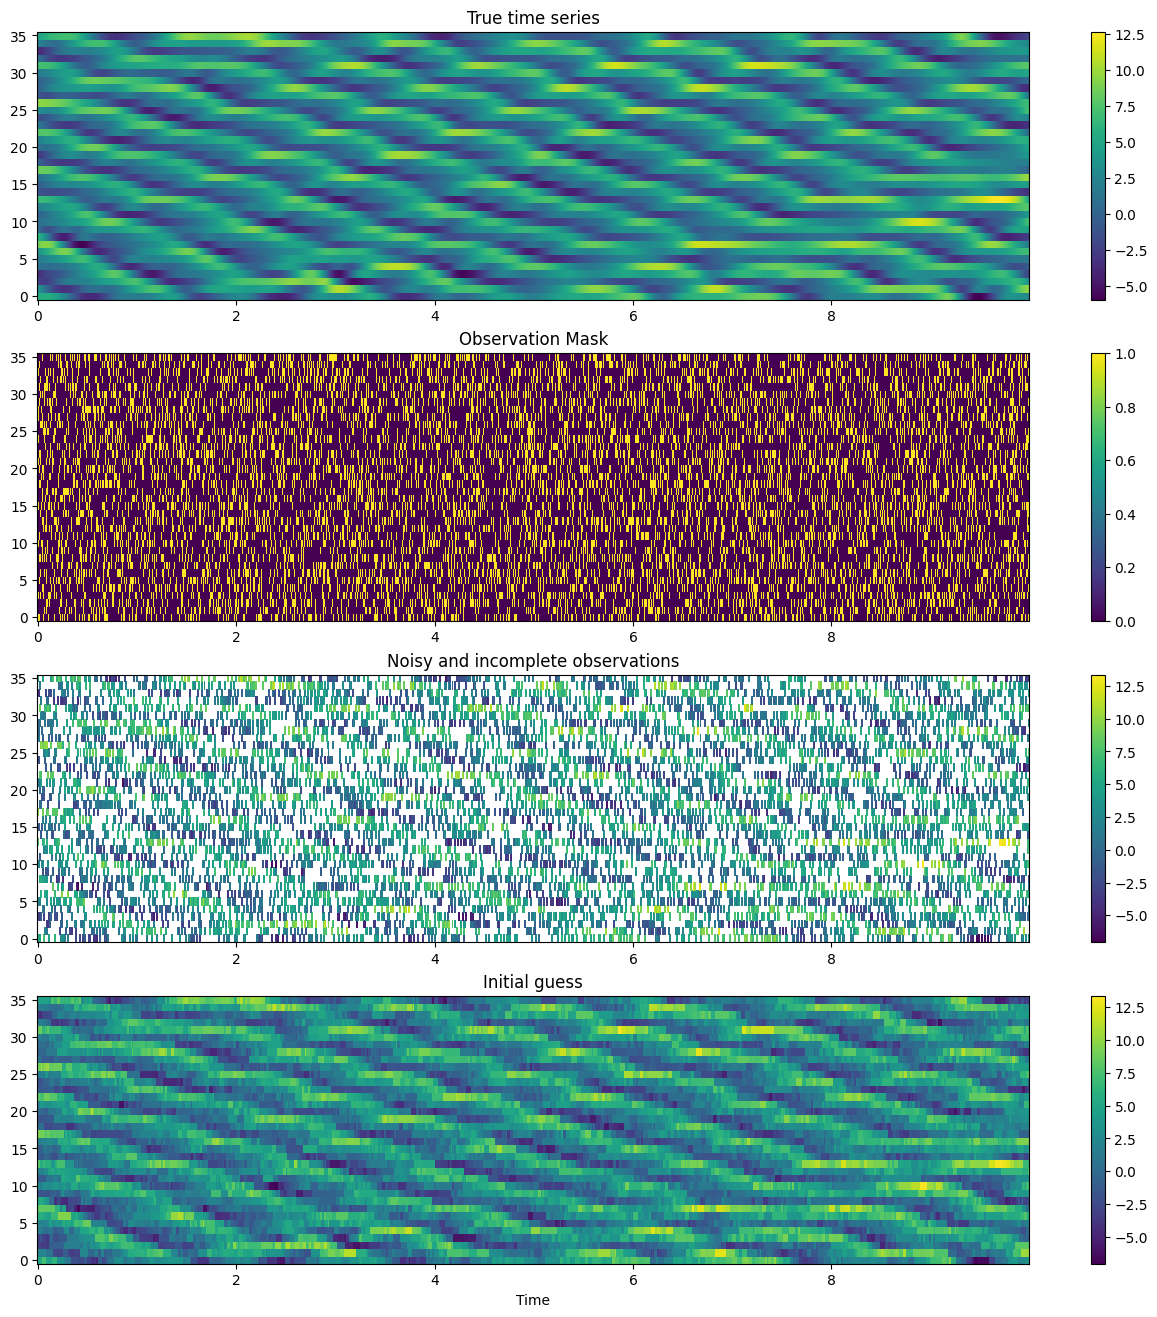

In [ ]:
valid_obs_x = observations.state.fields['x'][0].T
valid_obs_x[torch.logical_not(observations.mask.fields['x'][0].T)] = torch.nan

fig, ax = plt.subplots(4, 1, figsize=(16,16))

show_1dseqimg(true_ts.fields['x'][0].T, dt=time_step, ax=ax[0], title="True time series")
show_1dseqimg(observations.mask.fields['x'][0].T, dt=time_step, ax=ax[1], title="Observation Mask")
show_1dseqimg(valid_obs_x, dt=time_step, ax=ax[2], title="Noisy and incomplete observations")
show_1dseqimg(initialization.fields['x'][0].T, dt=time_step, ax=ax[3], title="Initial guess", x_label="Time")

In [ ]:
# we define a simple one-time-step function in order to fit the da-tools conventions
# In order to use the 4Dvar function, you should always have a function like this taking the state, dt, dynamic_inputs and static_inputs

def next_step_function(x: State, dt: float, dynamic_inputs: State, static_inputs: State):
    B, T = x.fields.batch_size[:2]
    x_tuple = (x.fields.reshape(-1)["x"], x.fields.reshape(-1)["y"]) # combine batch and time dimensions, leave others intact
    integrated = forward_operator.integrate(torch.arange(2) * dt, x_tuple)
    new_fields = TensorDict(x=integrated[0][:,1].unsqueeze(0), 
                            y=integrated[1][:,1].unsqueeze(0), 
                            batch_size=(B,T))
    return State(new_fields, time_axis=x.time_axis + dt)  # return State object, advancing time

In [ ]:
n_steps = true_ts.time_axis.nelement()

model_error_distribs = DiagonalGaussian(TensorDict(x=torch.zeros(1, n_steps - 1, K), 
                                                   y=torch.zeros(1, n_steps-1, K, J)),
                                        TensorDict(x=torch.ones(1, n_steps - 1, K), 
                                                   y=torch.ones(1, n_steps-1, K, J))*5)


In [ ]:
# This should take a few minutes to run
t0 = time()
assimilated_states = wc4dvar_single_window(next_step_function, 
                                          observations, 
                                          obs_op, 
                                          model_error_distribs,
                                          x_init=initialization, 
                                          optimizer_pars={'lr': 1e-1},
                                          alpha=1e4,
                                          n_steps=100,
                                          verbose=0)                                       
print(f'Total time for the 4Dvar optimization: {time() - t0} seconds')

assimilated_states = assimilated_states.detach()

Total time for the 4Dvar optimization: 169.87441062927246 seconds


torch.Size([1000, 36])
MSE for the reconstruction of the slow variables: 0.0436796173453331


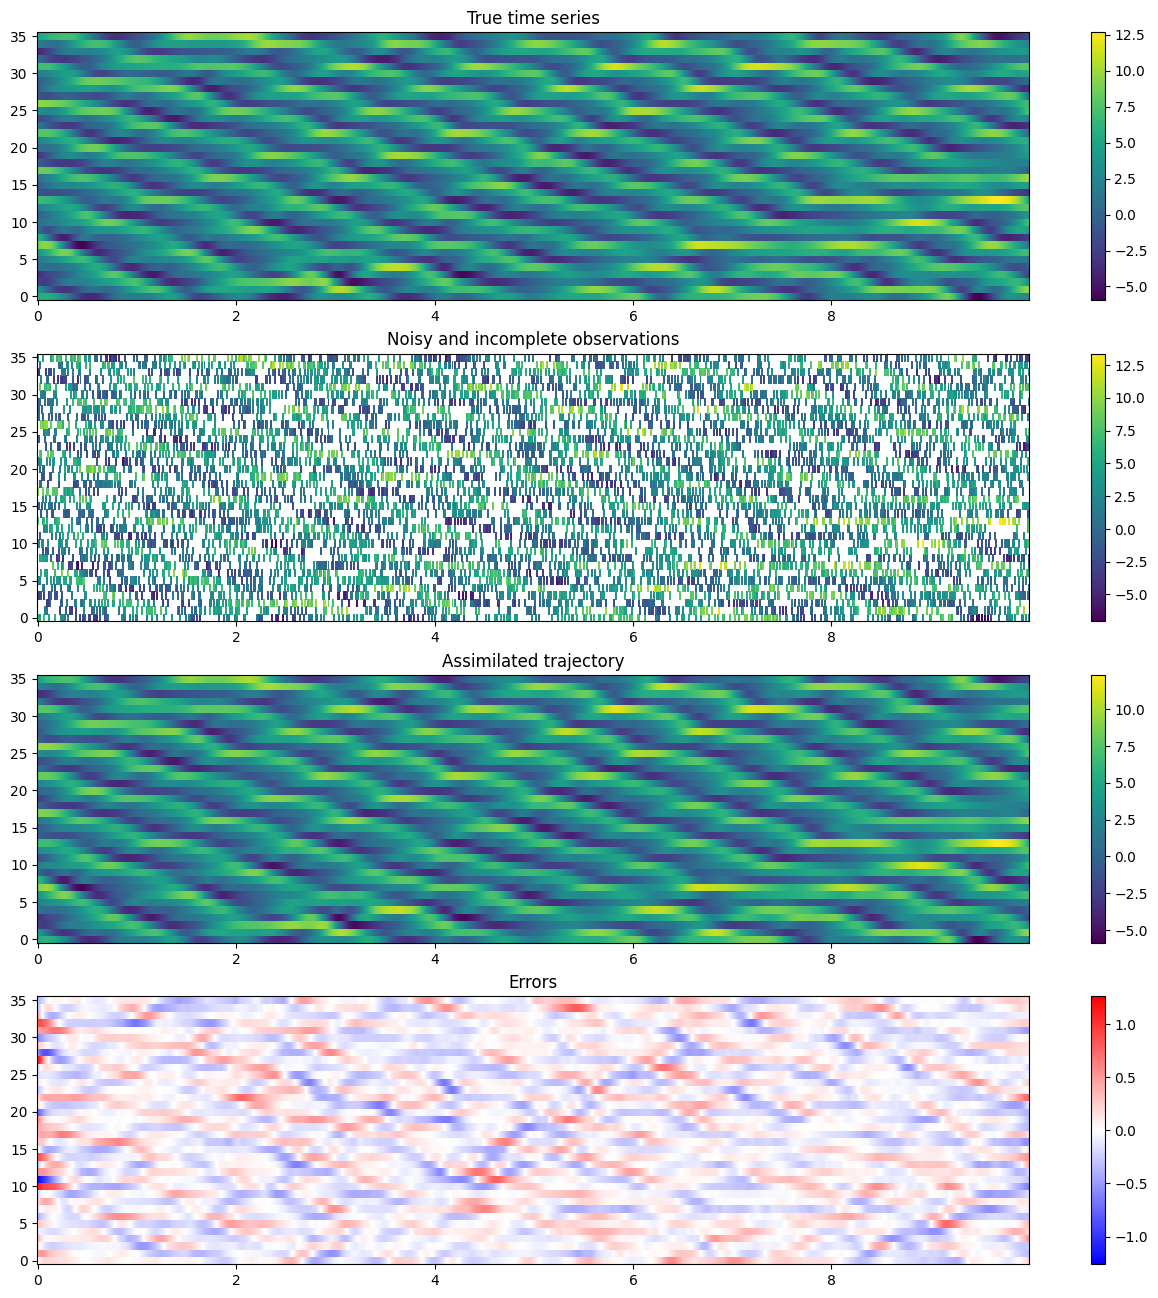

In [ ]:
assimilated_x = assimilated_states.fields['x'][0]
print(assimilated_x.shape)

errors_x = (assimilated_states - true_ts).fields['x'][0]
vmax_abs = torch.max(torch.abs(errors_x))

fig, ax = plt.subplots(4, 1, figsize=(16,16))
show_1dseqimg(true_ts.fields['x'][0].T, dt=time_step, ax=ax[0], title="True time series")
show_1dseqimg(valid_obs_x, dt=time_step, ax=ax[1], title="Noisy and incomplete observations")
show_1dseqimg(assimilated_x.T, dt=time_step, ax=ax[2], title="Assimilated trajectory")
show_1dseqimg(errors_x.T, dt=time_step, ax=ax[3], title="Errors", cmap="bwr", center_on_zero=True)

print(f"MSE for the reconstruction of the slow variables: {torch.mean(errors_x **2)}")

torch.Size([1000, 36, 10])
MSE for the reconstruction of the fast variables: 0.07930553704500198


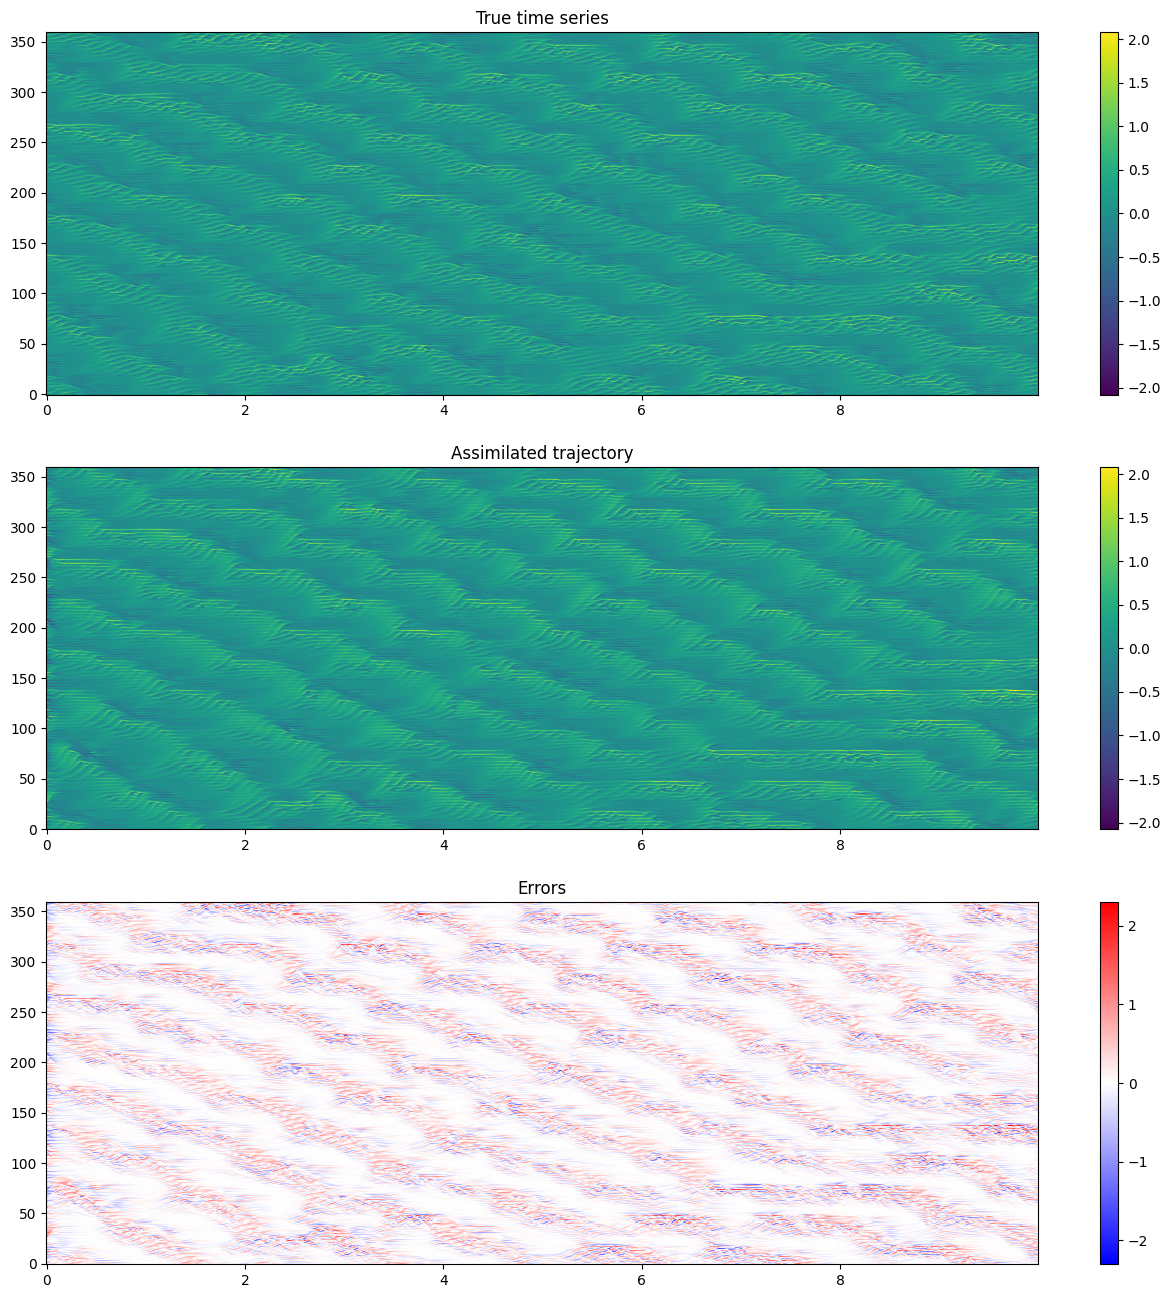

In [ ]:
assimilated_y = assimilated_states.fields['y'][0]
print(assimilated_y.shape)

errors_y = (assimilated_states - true_ts).fields['y'][0]
vmax_abs = torch.max(torch.abs(assimilated_y))

fig, ax = plt.subplots(3, 1, figsize=(16,16))
show_1dseqimg(true_ts.fields['y'][0].flatten(1,2).T, dt=time_step, ax=ax[0], vmin=-vmax_abs, vmax=vmax_abs, title="True time series")
show_1dseqimg(assimilated_y.flatten(1,2).T, dt=time_step, ax=ax[1], vmin=-vmax_abs, vmax=vmax_abs, title="Assimilated trajectory")
show_1dseqimg(errors_y.flatten(1,2).T, dt=time_step, ax=ax[2], title="Errors", cmap="bwr", center_on_zero=True)

print(f"MSE for the reconstruction of the fast variables: {torch.mean(errors_y **2)}")

Here, although no observations are available for the fast variables, we manage to obtain a crude reconstruction of their values over time, and taking them into account also enables to substantially improve the quality of the reconstruction for the slow variables.